In [2]:
#!pip install imblearn
import warnings
warnings.filterwarnings('ignore')

In [3]:
from pymongo import MongoClient
import pandas as pd

import numpy as np
from scipy import interp
from scipy.stats import ttest_1samp, wilcoxon, mannwhitneyu

import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.utils.fixes import signature

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids, NearMiss
from imblearn.metrics import classification_report_imbalanced
############


In [4]:
CYCU_1051SP = pd.read_csv('data/1051SP_w9.csv',encoding='utf-8') 
CYCU_1051SP = CYCU_1051SP.drop(['adjust_score','name','username','label_2'], axis=1)
CYCU_1051SP = CYCU_1051SP.astype(float)

In [5]:
datasets = 'CYCU_1051SP'

In [6]:
CYCU_1051SP['class'] = CYCU_1051SP['final_score'] < 60
CYCU_1051SP = CYCU_1051SP.drop(['final_score'], axis=1)

In [7]:
CYCU_1051SP

,video_watching_days,video_watching_times,video_watching_total_time,bbs_days,bbs_num,video_watching_num,video_time_between_start_first_watching,pre_watching_num,in_watching_num,re_watching_num,no_watching_num,post_watching_num,online_quiz,online_hw,pgm,quiz,class
0,10.0,33.0,1544.0,1.0,1.0,23.0,270.0,3.0,3.0,2.0,22.0,9.0,300.0,140.0,96.0,0.0,True
1,6.0,43.0,867.0,0.0,0.0,19.0,153.0,0.0,0.0,0.0,25.0,7.0,100.0,90.0,93.0,44.0,True
2,5.0,18.0,787.0,0.0,0.0,15.0,136.0,0.0,1.0,1.0,24.0,12.0,200.0,140.0,0.0,52.0,True
3,10.0,57.0,533.0,6.0,20.0,26.0,200.0,3.0,5.0,2.0,20.0,8.0,200.0,40.0,65.0,44.0,True
4,8.0,64.0,1944.0,0.0,0.0,41.0,240.0,0.0,1.0,1.0,24.0,16.0,300.0,90.0,97.0,44.0,True
5,1.0,2.0,2.0,1.0,1.0,1.0,52.0,0.0,0.0,0.0,25.0,0.0,100.0,200.0,97.0,64.0,True
6,12.0,27.0,249.0,6.0,21.0,17.0,158.0,2.0,1.0,2.0,24.0,9.0,300.0,260.0,66.0,44.0,True
7,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,40.0,True
8,18.0,88.0,3111.0,7.0,26.0,58.0,333.0,19.0,3.0,2.0,22.0,7.0,300.0,120.0,80.0,44.0,True
9,9.0,47.0,974.0,3.0,35.0,35.0,97.0,19.0,8.0,1.0,17.0,1.0,300.0,120.0,62.0,64.0,True


In [8]:
X = CYCU_1051SP.drop(['class'], axis=1)
X = X.values
y = CYCU_1051SP['class']

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)

clf_binary = svm.SVC(kernel='rbf', 
                     probability=True,
                     cache_size=700,
                     random_state=5)

clf_one = svm.OneClassSVM(kernel="rbf",
                         cache_size=700,
                        random_state=5)



In [9]:


def compute_roc (X, y, title):
    
    tprs = []
    aucs = []
    #acc = []
    mean_fpr = np.linspace(0, 1, 100)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    #fig, ax1 = plt.su
    
    i = 0
    for train, test in cv.split(X, y):

        y_pred = clf_binary.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], y_pred[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        acc = accuracy_score(y[test], y_pred[:, 1].round())
        precision, recall, _ = precision_recall_curve(y[test], y_pred[:, 1])
        average_precision = average_precision_score(y[test], y_pred[:, 1])
        #accs.append(accuracy_score(y[test], y_pred[:, 1].round()))
        ax1.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f, ACC = %0.2f)' % (i, roc_auc, acc))

        i += 1
    ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax1.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver operating characteristic of '+ title)
    ax1.legend(loc="lower right")
    
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    ax2.step(recall, precision, color='b', alpha=0.2, where='post')
    ax2.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlim([0.0, 1.0])
    ax2.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
    image_name = './images/' + datasets + '_' + title + '.png'
    fig.savefig(image_name, dpi=300)
    
    return aucs


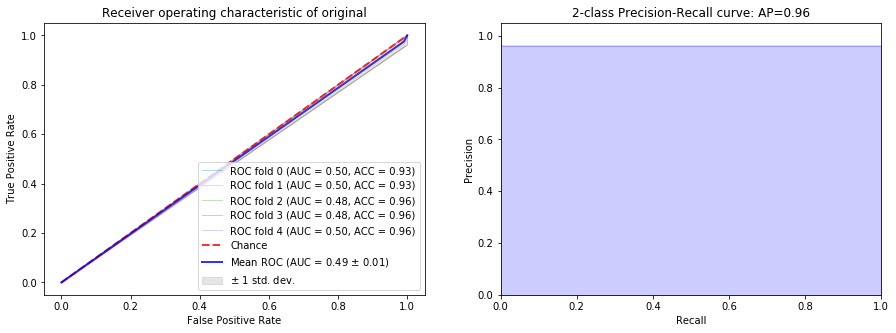

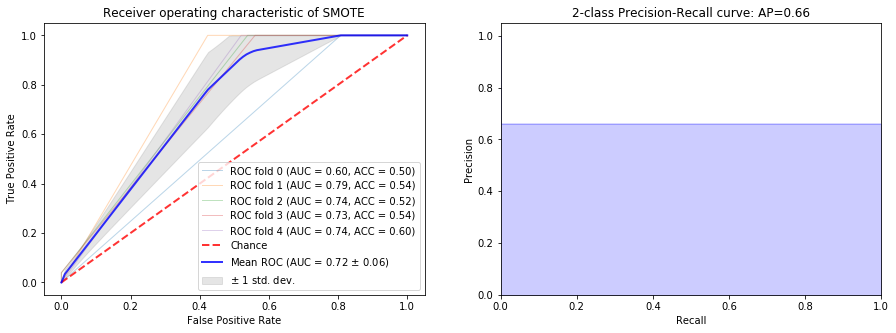

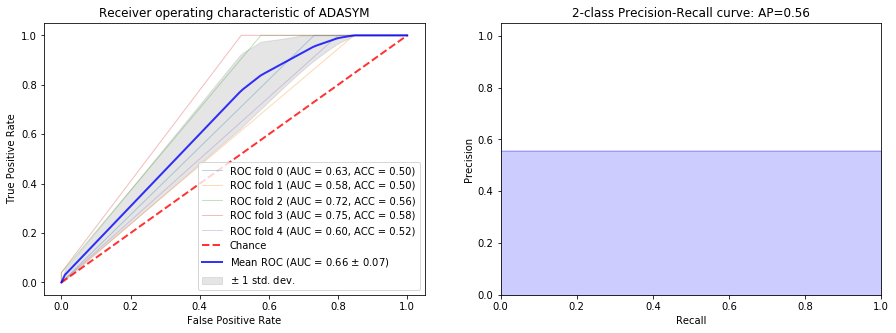

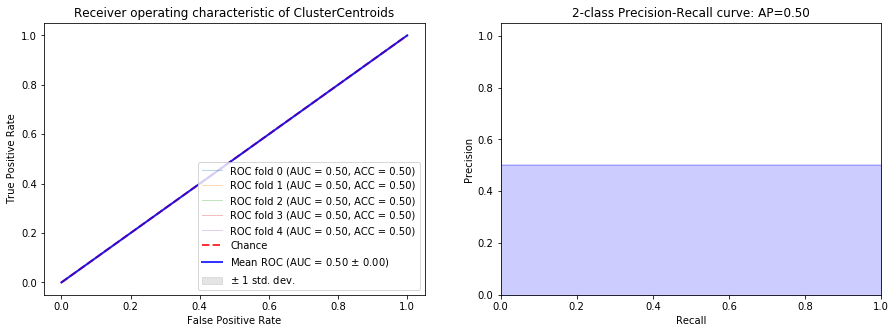

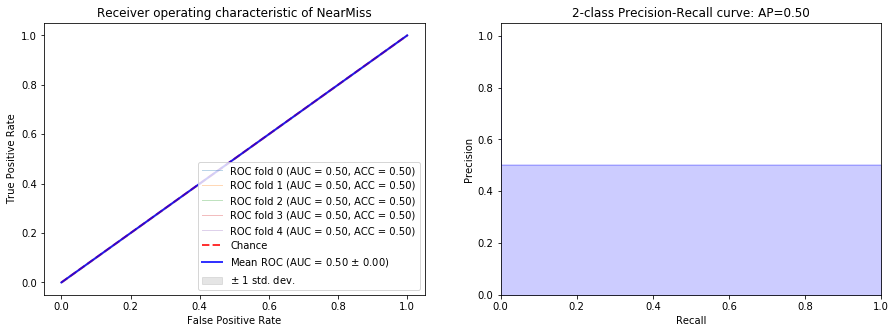

In [10]:
auc_ori = compute_roc(X, y, title='original')

res_X, res_y = SMOTE(ratio = 1.0).fit_sample(X, y)
auc_sm = compute_roc(res_X, res_y, title='SMOTE')

res_X, res_y = ADASYN(ratio = 1.0).fit_sample(X, y)
auc_ada = compute_roc(res_X, res_y, title='ADASYM')

res_X, res_y = ClusterCentroids(random_state=0).fit_sample(X, y)
auc_cc = compute_roc(res_X, res_y, title='ClusterCentroids')

res_X, res_y = NearMiss(random_state=0).fit_sample(X, y)
auc_nm = compute_roc(res_X, res_y, title='NearMiss')
